<a href="https://colab.research.google.com/github/jpdeleon/chronos/blob/master/notebooks/examples-age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install git+https://github.com/jpdeleon/chronos.git@master

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl

import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
toiid=1063

#initialize
star = cr.Star(toiid=toiid)

Target: TOI 1063
Searching Vizier: (230.555 -83.0562) with radius=3.0 arcsec


## age using rotation period

## get lightcurves

In [4]:
sc = cr.ShortCadence(toiid=toiid)
sc.all_sectors

Target: TOI 1063
Available sectors: [12 13]
Using sector=12.
Searching lightcurvefile for TIC 406976746 (sector 12)
Found 1 lightcurves
Using TESS short cadence.



array([12, 13])

Searching lightcurvefile for TIC 406976746 (sector 13)
Found 1 lightcurves


Text(0.5, 1.0, 'TIC 406976746 (sector [12 13])')

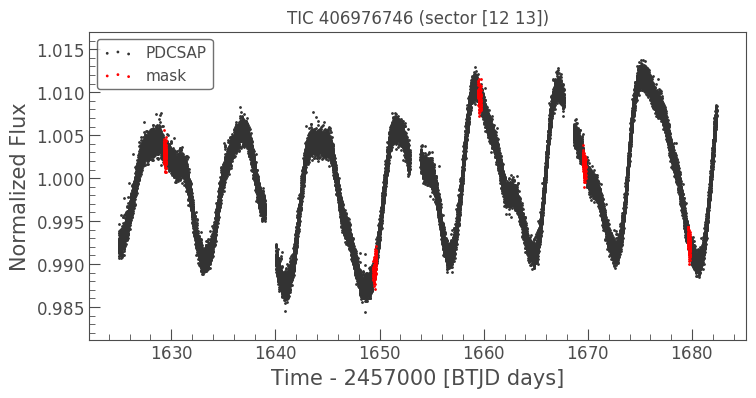

In [5]:
lc1 = sc.get_lc(lctype='pdcsap', sector=sc.all_sectors[0])
tmask1 = cr.get_transit_mask(lc1,
                            period=sc.toi_period,
                            epoch=sc.toi_epoch-cr.TESS_TIME_OFFSET,
                            duration_hours=sc.toi_duration
                            )

lc2 = sc.get_lc(lctype='pdcsap', sector=sc.all_sectors[1])
tmask2 = cr.get_transit_mask(lc2,
                            period=sc.toi_period,
                            epoch=sc.toi_epoch-cr.TESS_TIME_OFFSET,
                            duration_hours=sc.toi_duration
                            )
#merge multi-sector lc
lc = lc1[~tmask1].append(lc2[~tmask2])
lcm = lc1[tmask1].append(lc2[tmask2])

ax = lc.scatter(label='PDCSAP')
lcm.scatter(ax=ax, label='mask', c='r')
ax.set_title(f'TIC {sc.ticid} (sector {sc.all_sectors})')

Using Lomb-Scargle method
P=8.18+/-0.82 d


Text(0.5, 0.98, 'TIC 406976746 (sector [12 13])')

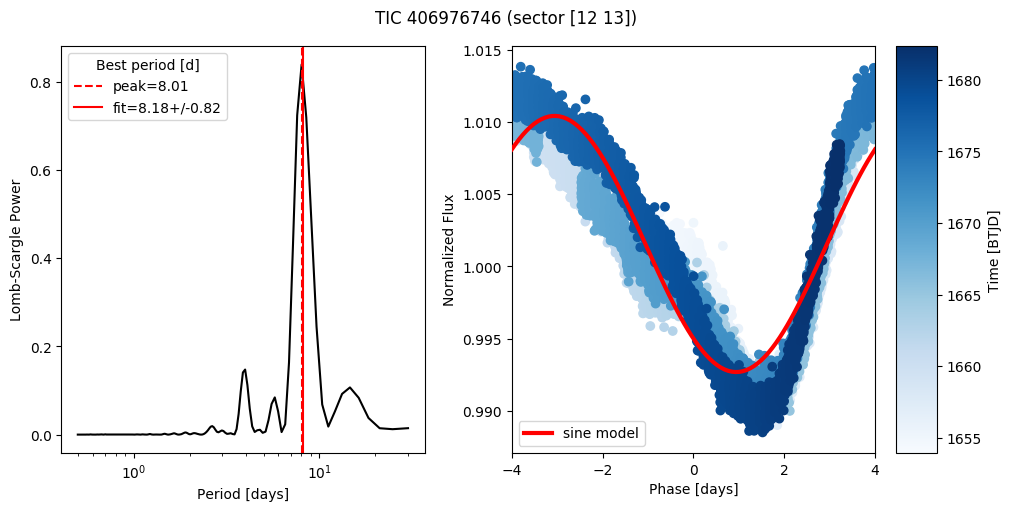

In [6]:
lc = sc.lc_pdcsap.remove_outliers().normalize()
fig = cr.plot_rotation_period(lc.time, lc.flux)
fig.suptitle(f'TIC {sc.ticid} (sector {sc.all_sectors})')

Using Lomb-Scargle method
P=8.18+/-0.82 d


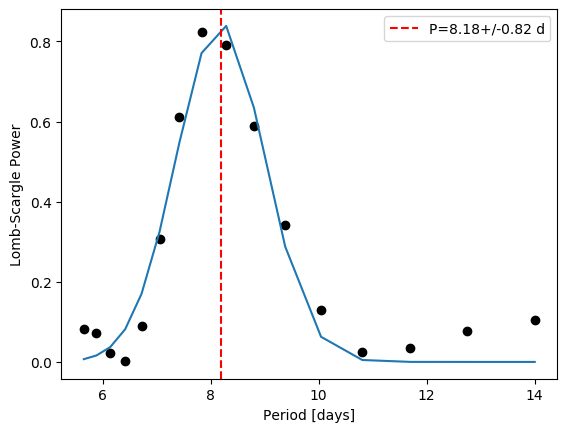

In [7]:
prot, prot_err = cr.get_rotation_period(lc.time, lc.flux, plot=True)

Estimating age from rotation period

Querying Gaia DR2 catalog for ra,dec=(230.555 -83.0562) within 3.0 arcsec.
High proper-motion star:
(pmra,pmdec)=(-89.12,-9.60) mas/yr
Querying TIC catalog for ra,dec=(230.555 -83.0562) within 3.0 arcsec.
Gaia and TIC catalog cross-match succeeded.
Estimating age using gyrochronology

gyro age = 506.51 + 116.93 - 87.63 Myr using rotation period 8.18+/-0.82d


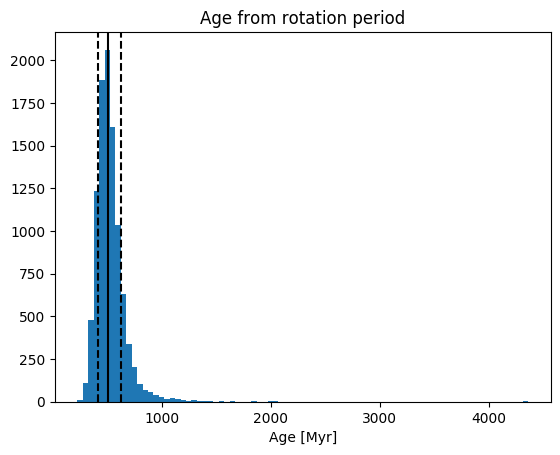

In [8]:
#get age results
age,age_plus,age_minus,samples = star.get_age(method='prot', 
                                              prot=(prot,prot_err), 
                                              return_samples=True,
                                              plot=True
                                             )

## age using rotation amplitude

In [9]:
amp = star.get_rotation_amplitude(lc, prot=(prot,prot_err))
amp

(0.018534064, 0.0033820597)

Estimating age using rotation amplitude

More than 39.46% of derived ages is outside (0.01,4) Gyr
gyro age = 314.59 + 757.22 - 255.04 Myr using rotation amplitude 1.85+/-0.34%


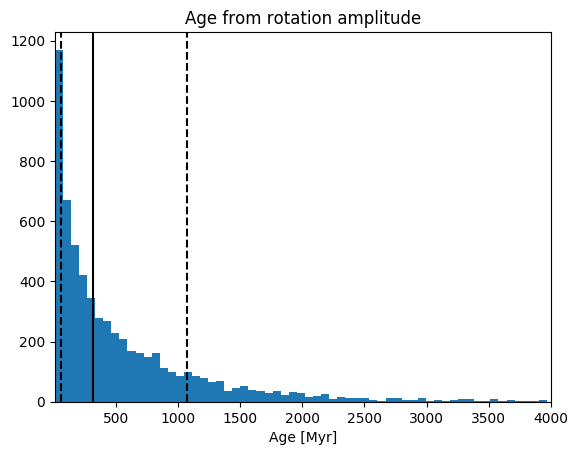

In [10]:
age,age_plus,age_minus,samples = star.get_age(method='amp', 
                                           amp=amp, 
                                           return_samples=True,
                                           plot=True
                                          )

## age using gyrochronology+isochrones

In [11]:
#spectroscopic constraints from SMARTS/CHIRON
teff = (5332,100) 
logg = (4.56, 0.05)
feh = (-0.09, 0.05)

In [13]:
star.get_iso_params(teff=teff,
                    logg=logg,
                    feh=feh,
                    bands=['j','h','k'] #no NIR photometries
                  )

Gaia and TIC catalog cross-match succeeded.


{'Teff': [5332.0, 100.0],
 'feh': [-0.09, 0.05],
 'logg': [4.56, 0.05],
 'parallax': [16.25231096261722, 0.1035314124863975]}

In [16]:
star.run_stardate(prot=(prot,prot_err), #add gyro age constraint
                         nsteps=1000
                        )

Gaia and TIC catalog cross-match succeeded.
Input parameters:
{'Av': [0.305956668779254, 0.01],
 'H': [7.997, 0.036],
 'J': [8.352, 0.027],
 'K': [7.858, 0.036],
 'parallax': [16.25231096261722, 0.1035314124863975]}
Init isochrones parameters:
{'Av': 0.0045,
 'EEP': 329.58,
 '[Fe/H]': -0.0478,
 'ln(Distance)': 5.560681631015528,
 'log10(Age [yr])': 9.5596}


100%|██████████| 1000/1000 [00:15<00:00, 61.05it/s]

nsteps 1000 burnin 500


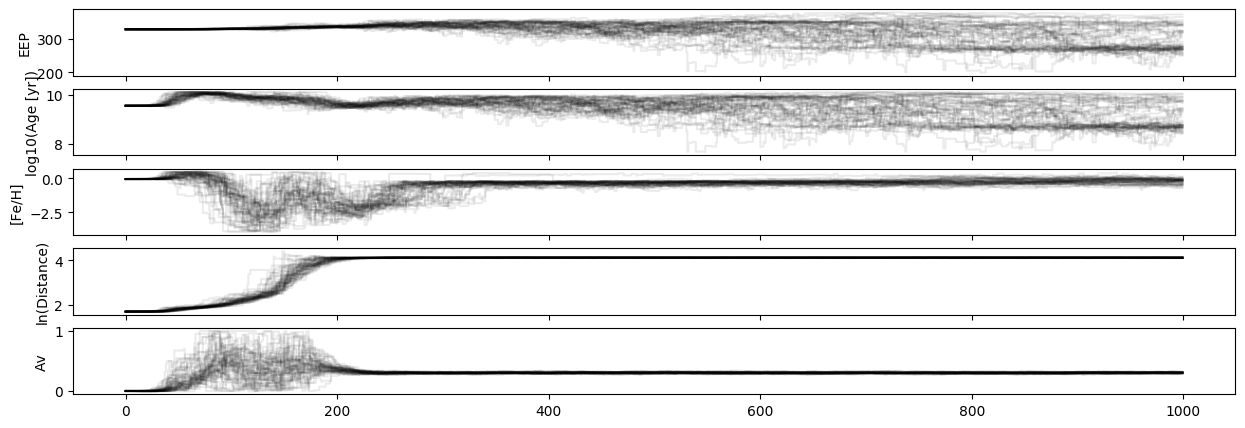

In [17]:
fig = star.plot_flatchain();

Estimating age from isochrones

iso+gyro age = 2004.13 + 6115.02 - 1530.10 Myr


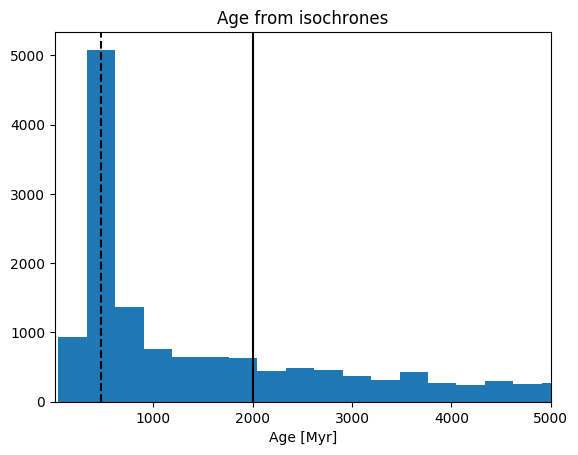

In [18]:
#get age results
burnin=600
age,age_plus,age_minus,samples = star.get_age(method='isochrones', 
                                           return_samples=True, 
                                           burnin=burnin, 
                                           plot=True
                                          )

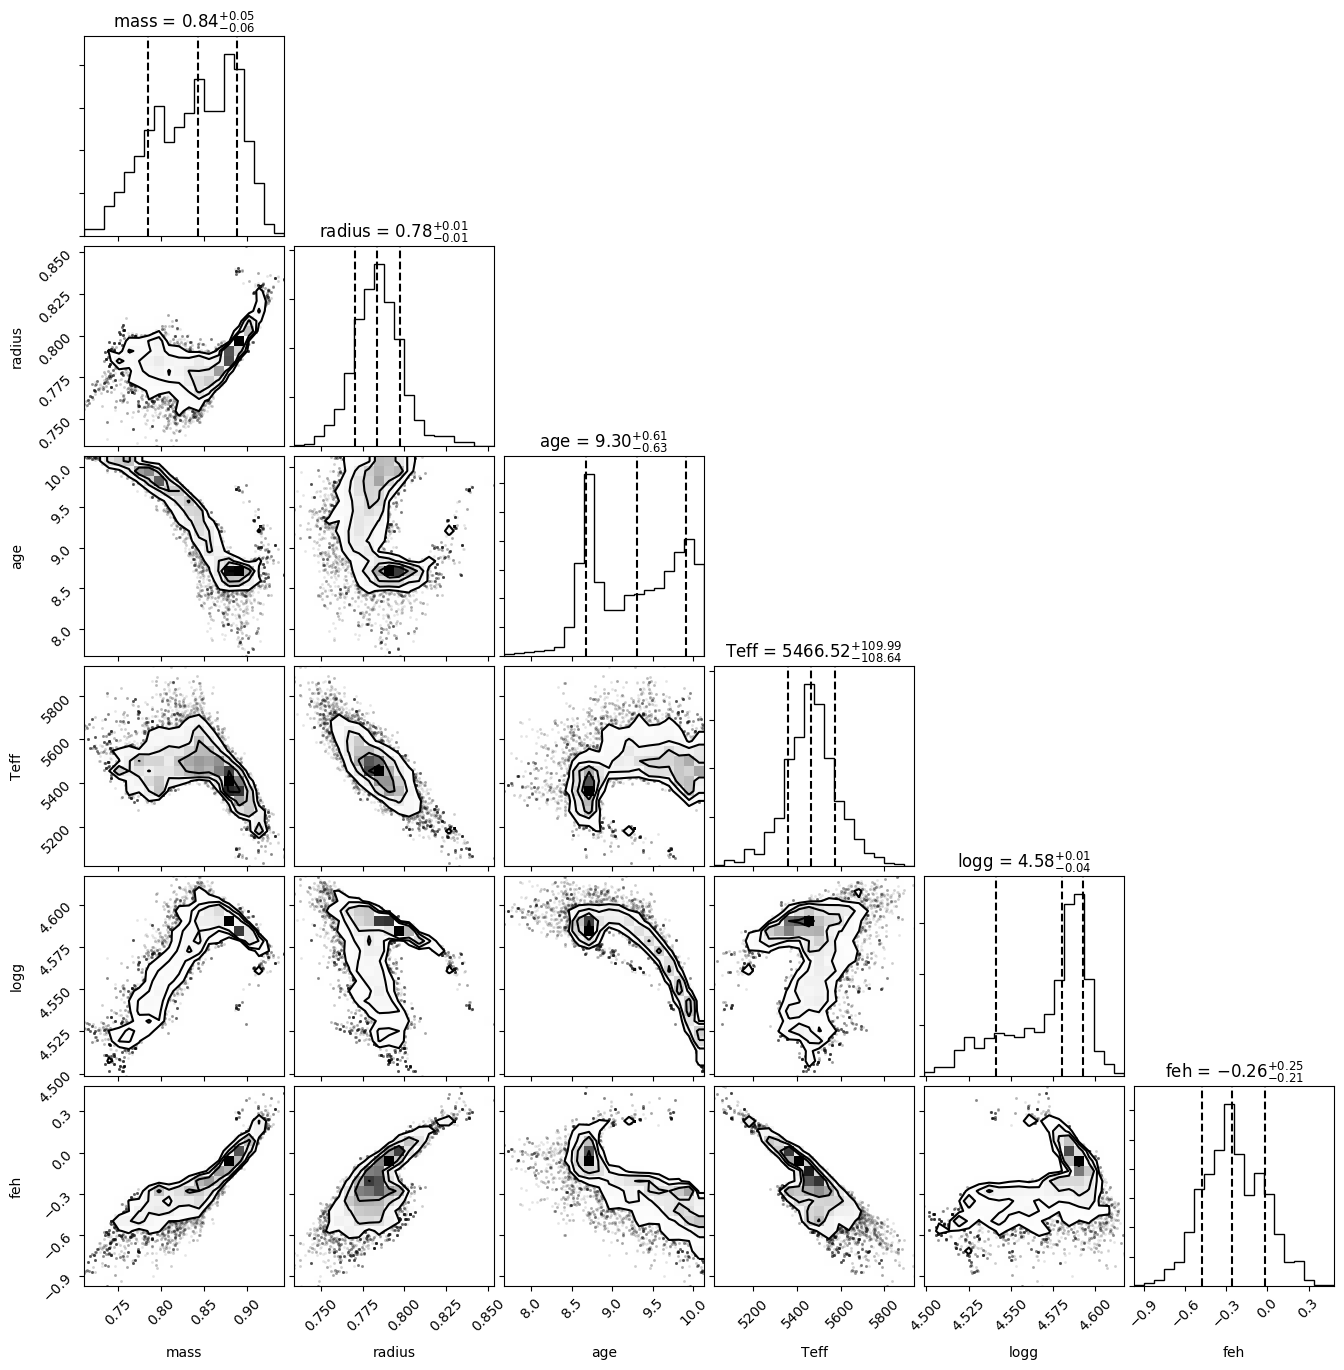

In [20]:
fig = star.plot_corner(burnin=burnin, use_isochrones=False)

Note that the default initial values in isochrone fitting are:

In [21]:
star.iso_params_init

{'EEP': 329.58,
 'log10(Age [yr])': 9.5596,
 '[Fe/H]': -0.0478,
 'ln(Distance)': 5.560681631015528,
 'Av': 0.0045}

To estimate EEP based on initial stellar parameters estimates:

In [24]:
#estimate EEP
from isochrones.mist import MIST_EvolutionTrack
mist_track = MIST_EvolutionTrack()

mass0, logage0, feh0= 0.7, np.log10(1e9), 0.012
d = mist_track.generate(mass0, logage0, feh0, accurate=False) 
eep0 = d['eep'].values[0]

iso_params0 = [eep0, logage0, feh0, star.target_coord.distance.pc, star.estimate_Av()]

#first run stardate
star = star.run_stardate(iso_params0=iso_params0, prot=(prot,prot_err), nsteps=1000)

  1%|          | 6/1000 [00:00<00:16, 59.50it/s]

Gaia and TIC catalog cross-match succeeded.
Input parameters:
{'Av': [0.305956668779254, 0.01],
 'H': [7.997, 0.036],
 'J': [8.352, 0.027],
 'K': [7.858, 0.036],
 'parallax': [16.25231096261722, 0.1035314124863975]}
Init isochrones parameters:
{'Av': 0.0045,
 'EEP': 329.58,
 '[Fe/H]': -0.0478,
 'ln(Distance)': 5.560681631015528,
 'log10(Age [yr])': 9.5596}


100%|██████████| 1000/1000 [00:17<00:00, 58.27it/s]

nsteps 1000 burnin 500
